# Position Analysis (Scaled)
Standalone notebook to analyze walk-forward position exports without modifying the original analysis notebook.

In [10]:
# Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_palette('husl')
ALLOCATION_FILE = "walkforward_positions.csv"  # positions export
RETURNS_FILE = "walkforward_oos_returns.csv"  # OOS returns export (date, return)
BTC_SYMBOL = "BTCUSDT"
DATA_DIRECTORY = "/Users/chinjieheng/Documents/data/binance_dailydata"
FIXED_CAPITAL = 500  # if you want $ sizing
capital_scale = 1.0  # set to FIXED_CAPITAL for dollar view, or leave 1.0 for exposure units
capital_unit = "$" if capital_scale != 1 else "exposure units"
print(f"Allocation file: {ALLOCATION_FILE}")
print(f"Data directory: {DATA_DIRECTORY}")
print(f"Capital scale: {capital_scale} ({capital_unit})")


Allocation file: walkforward_positions.csv
Data directory: /Users/chinjieheng/Documents/data/binance_dailydata
Capital scale: 1.0 (exposure units)


In [11]:
# Load positions + returns + BTC benchmark
returns_path = Path(RETURNS_FILE)
allocations_df = pd.read_csv(ALLOCATION_FILE)
allocations_df['date'] = pd.to_datetime(allocations_df['date'])

returns_df = pd.DataFrame()
if returns_path.exists():
    returns_df = pd.read_csv(returns_path, header=None, names=['date', 'oos_return'])
    returns_df['date'] = pd.to_datetime(returns_df['date'], errors='coerce')
    if hasattr(returns_df['date'], 'dt') and returns_df['date'].dt.tz is not None:
        returns_df['date'] = returns_df['date'].dt.tz_localize(None)
    returns_df = returns_df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)
    print(f"Loaded returns: {len(returns_df)} rows from {returns_path}")
else:
    print(f"Returns file not found: {returns_path}")
    returns_df = pd.DataFrame()

btc_ret_df = pd.DataFrame()
btc_path = Path(DATA_DIRECTORY) / f"{BTC_SYMBOL}-1d-data.parquet"
if btc_path.exists():
    btc_df = pd.read_parquet(btc_path)
    if 'timestamp' in btc_df.columns:
        date_series = pd.to_datetime(btc_df['timestamp'], errors='coerce')
    elif 'date' in btc_df.columns:
        date_series = pd.to_datetime(btc_df['date'], errors='coerce')
    elif pd.api.types.is_datetime64_any_dtype(btc_df.index):
        date_series = pd.to_datetime(btc_df.index, errors='coerce')
    elif pd.api.types.is_numeric_dtype(btc_df.index):
        date_series = pd.to_datetime(btc_df.index.to_numpy(), unit='ms', errors='coerce')
    else:
        date_series = pd.to_datetime(btc_df.index, errors='coerce')
    btc_df = btc_df.reset_index(drop=True)
    date_series = pd.Series(date_series).reset_index(drop=True)
    btc_df['date'] = date_series
    if hasattr(btc_df['date'], 'dt') and btc_df['date'].dt.tz is not None:
        btc_df['date'] = btc_df['date'].dt.tz_localize(None)
    btc_df = btc_df.dropna(subset=['date']).sort_values('date')
    if 'close' in btc_df.columns:
        btc_df['btc_return'] = btc_df['close'].pct_change()
        btc_ret_df = btc_df[['date', 'btc_return']].dropna()
        print(f"Loaded BTC returns: {len(btc_ret_df)} rows from {btc_path.name}")
    else:
        print(f"BTC close column missing in {btc_path.name}")
else:
    print(f"BTC file not found: {btc_path}")

for col in ['oos_return', 'daily_return']:
    if col in allocations_df.columns:
        allocations_df[col] = pd.to_numeric(allocations_df[col], errors='coerce')

# Build continuous daily calendar so gaps disappear
start_date = allocations_df['date'].min()
end_date = allocations_df['date'].max()
dates_full = pd.DataFrame({'date': pd.date_range(start_date, end_date, freq='D')})

analysis_df = dates_full.merge(allocations_df, on='date', how='left')
if not returns_df.empty:
    analysis_df = analysis_df.merge(returns_df, on='date', how='left')
if not btc_ret_df.empty:
    analysis_df = analysis_df.merge(btc_ret_df, on='date', how='left')

# Flag actual rebalance days before any fill
analysis_df['rebalance_day'] = False
rebalance_cols = [c for c in ['long_allocations', 'short_allocations'] if c in analysis_df.columns]
if rebalance_cols:
    analysis_df['rebalance_day'] = analysis_df[rebalance_cols].notna().any(axis=1)

# Do not forward-fill allocations; treat missing as flat
for col in ['long_allocations', 'short_allocations']:
    if col in analysis_df.columns:
        analysis_df[col] = analysis_df[col].fillna('')

# Fill numeric exposures/meta with zeros (no carry) for count/exposure columns
zero_cols = [
    'long_positions', 'short_positions',
    'total_long_exposure', 'total_short_exposure'
]
for col in zero_cols:
    if col in analysis_df.columns:
        analysis_df[col] = analysis_df[col].fillna(0)

# Track whether positions are active after fill
positions_cols = [c for c in ['long_allocations', 'short_allocations'] if c in analysis_df.columns]
if positions_cols:
    analysis_df['positions_active'] = analysis_df[positions_cols].notna().any(axis=1)

for col in ['oos_return', 'daily_return', 'btc_return']:
    if col in analysis_df.columns:
        analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

# Align OOS returns to the entry day (positions on date apply to next-day PnL)
if 'oos_return' in analysis_df.columns:
    analysis_df['oos_return_entry'] = analysis_df['oos_return'].shift(-1)

allocations_df = analysis_df
RETURN_COL = None
if 'oos_return_entry' in allocations_df.columns:
    RETURN_COL = 'oos_return_entry'
elif 'oos_return' in allocations_df.columns:
    RETURN_COL = 'oos_return'
elif 'daily_return' in allocations_df.columns:
    RETURN_COL = 'daily_return'

print(f"Records (calendar): {len(allocations_df)}")
print(f"Date range: {allocations_df['date'].min().date()} -> {allocations_df['date'].max().date()}")
print(f"Columns: {list(allocations_df.columns)}")
print(f"Return column used: {RETURN_COL}")


Loaded returns: 867 rows from walkforward_oos_returns.csv
Loaded BTC returns: 2205 rows from BTCUSDT-1d-data.parquet
Records (calendar): 768
Date range: 2023-09-03 -> 2025-10-09
Columns: ['date', 'long_tickers', 'short_tickers', 'long_allocations', 'short_allocations', 'long_positions', 'short_positions', 'total_long_exposure', 'total_short_exposure', 'turnover', 'daily_return', 'iteration', 'train_start', 'train_end', 'test_start', 'test_end', 'oos_return', 'btc_return', 'rebalance_day', 'positions_active', 'oos_return_entry']
Return column used: oos_return_entry


In [12]:
# Compute long/short returns from allocations using forward price moves
from collections import defaultdict

COST_BPS = 0.0005  # 5 bps cost applied when positions change (rebalance)

def parse_allocations(val):
    out = {}
    if isinstance(val, str) and val:
        for part in val.split('|'):
            if ':' in part:
                sym, w = part.split(':', 1)
                try:
                    out[sym] = float(w)
                except ValueError:
                    continue
    return out

tickers = set()
for s in allocations_df.get('long_allocations', []):
    tickers.update(parse_allocations(s).keys())
for s in allocations_df.get('short_allocations', []):
    tickers.update(parse_allocations(s).keys())

price_frames = []
for sym in sorted(tickers):
    p = Path(DATA_DIRECTORY) / f"{sym}-1d-data.parquet"
    if not p.exists():
        continue
    df = pd.read_parquet(p)
    if 'timestamp' in df.columns:
        dates = pd.to_datetime(df['timestamp'], errors='coerce')
    elif 'date' in df.columns:
        dates = pd.to_datetime(df['date'], errors='coerce')
    elif pd.api.types.is_datetime64_any_dtype(df.index):
        dates = pd.to_datetime(df.index, errors='coerce')
    elif pd.api.types.is_numeric_dtype(df.index):
        dates = pd.to_datetime(df.index.to_numpy(), unit='ms', errors='coerce')
    else:
        dates = pd.to_datetime(df.index, errors='coerce')
    df = df.reset_index(drop=True)
    df['date'] = dates
    df = df.dropna(subset=['date'])
    if hasattr(df['date'], 'dt') and df['date'].dt.tz is not None:
        df['date'] = df['date'].dt.tz_localize(None)
    df = df.sort_values('date')
    if 'close' not in df.columns:
        continue
    df['fwd_return'] = df['close'].shift(-1) / df['close'] - 1.0
    ser = df.set_index('date')['fwd_return'].rename(sym).dropna()
    price_frames.append(ser)

if price_frames:
    asset_returns = pd.concat(price_frames, axis=1, sort=False)
    asset_returns = asset_returns[~asset_returns.index.duplicated(keep='first')].sort_index()
else:
    asset_returns = pd.DataFrame()

# prepare previous-day allocations to stamp PnL on exit day
allocations_df['long_allocations_prev'] = allocations_df.get('long_allocations', pd.Series([], dtype=object)).shift(1)
allocations_df['short_allocations_prev'] = allocations_df.get('short_allocations', pd.Series([], dtype=object)).shift(1)
mask_rebal = allocations_df.get('rebalance_day', pd.Series(False, index=allocations_df.index)).astype(bool)
mask_rebal_prev = mask_rebal.shift(1).fillna(False)

def compute_entry_returns(row):
    date = row['date']
    if asset_returns.empty or date not in asset_returns.index:
        return pd.Series({'long_return_mtm': 0.0, 'short_return_mtm': 0.0})
    rets = asset_returns.loc[date]
    long_w = parse_allocations(row.get('long_allocations', ''))
    short_w = parse_allocations(row.get('short_allocations', ''))
    long_ret = sum(rets.get(sym, 0.0) * w for sym, w in long_w.items())
    short_ret = sum(rets.get(sym, 0.0) * w for sym, w in short_w.items())
    return pd.Series({'long_return_mtm': long_ret, 'short_return_mtm': short_ret})

def compute_exit_returns(row):
    date = row['date']
    if asset_returns.empty or date not in asset_returns.index:
        return pd.Series({'long_return_rebalance_exit': 0.0, 'short_return_rebalance_exit': 0.0})
    rets = asset_returns.loc[date]
    long_w = parse_allocations(row.get('long_allocations_prev', ''))
    short_w = parse_allocations(row.get('short_allocations_prev', ''))
    long_ret = sum(rets.get(sym, 0.0) * w for sym, w in long_w.items())
    short_ret = sum(rets.get(sym, 0.0) * w for sym, w in short_w.items())
    return pd.Series({'long_return_rebalance_exit': long_ret, 'short_return_rebalance_exit': short_ret})

if allocations_df.empty:
    print('No allocations; skipping side return computation.')
else:
    # entry-day mtm (positions at date, fwd return date->date+1)
    side_entry = allocations_df.apply(compute_entry_returns, axis=1)
    allocations_df[['long_return_mtm', 'short_return_mtm']] = side_entry
    allocations_df['net_return_mtm'] = allocations_df['long_return_mtm'] + allocations_df['short_return_mtm']
    allocations_df.loc[~mask_rebal, ['long_return_mtm', 'short_return_mtm', 'net_return_mtm']] = 0.0

    # rebalance-only (entry day)
    allocations_df['long_return_rebalance'] = allocations_df['long_return_mtm']
    allocations_df['short_return_rebalance'] = allocations_df['short_return_mtm']
    allocations_df['net_return_rebalance'] = allocations_df['long_return_rebalance'] + allocations_df['short_return_rebalance']

    # exit-day aligned (positions from previous day, fwd return previous->current)
    side_exit = allocations_df.apply(compute_exit_returns, axis=1)
    allocations_df[['long_return_rebalance_exit', 'short_return_rebalance_exit']] = side_exit
    allocations_df['net_return_rebalance_exit'] = allocations_df['long_return_rebalance_exit'] + allocations_df['short_return_rebalance_exit']
    allocations_df.loc[~mask_rebal_prev, ['long_return_rebalance_exit', 'short_return_rebalance_exit', 'net_return_rebalance_exit']] = 0.0

    # Apply trading cost on rebalance days to entry and exit PnL
    allocations_df['net_return_rebalance'] = allocations_df['net_return_rebalance'] - (mask_rebal.astype(float) * COST_BPS)
    allocations_df['net_return_mtm'] = allocations_df['net_return_mtm'] - (mask_rebal.astype(float) * COST_BPS)
    allocations_df['net_return_rebalance_exit'] = allocations_df['net_return_rebalance_exit'] - (mask_rebal_prev.astype(float) * COST_BPS)

    # Legacy columns: mtm with cost on entry-day rebalances
    allocations_df['long_return'] = allocations_df['long_return_mtm']
    allocations_df['short_return'] = allocations_df['short_return_mtm']
    allocations_df['net_return_reconstructed'] = allocations_df['net_return_mtm']

    print(f"Computed side returns for {side_entry.dropna().shape[0]} rows out of {len(allocations_df)}")


Computed side returns for 768 rows out of 768


/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_36108/1537111117.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask_rebal_prev = mask_rebal.shift(1).fillna(False)


Calculating total portfolio size by summing absolute weights × capital_scale...
Avg: 1.00 exposure unitsMax: 1.00 exposure unitsMin: 1.00 exposure units


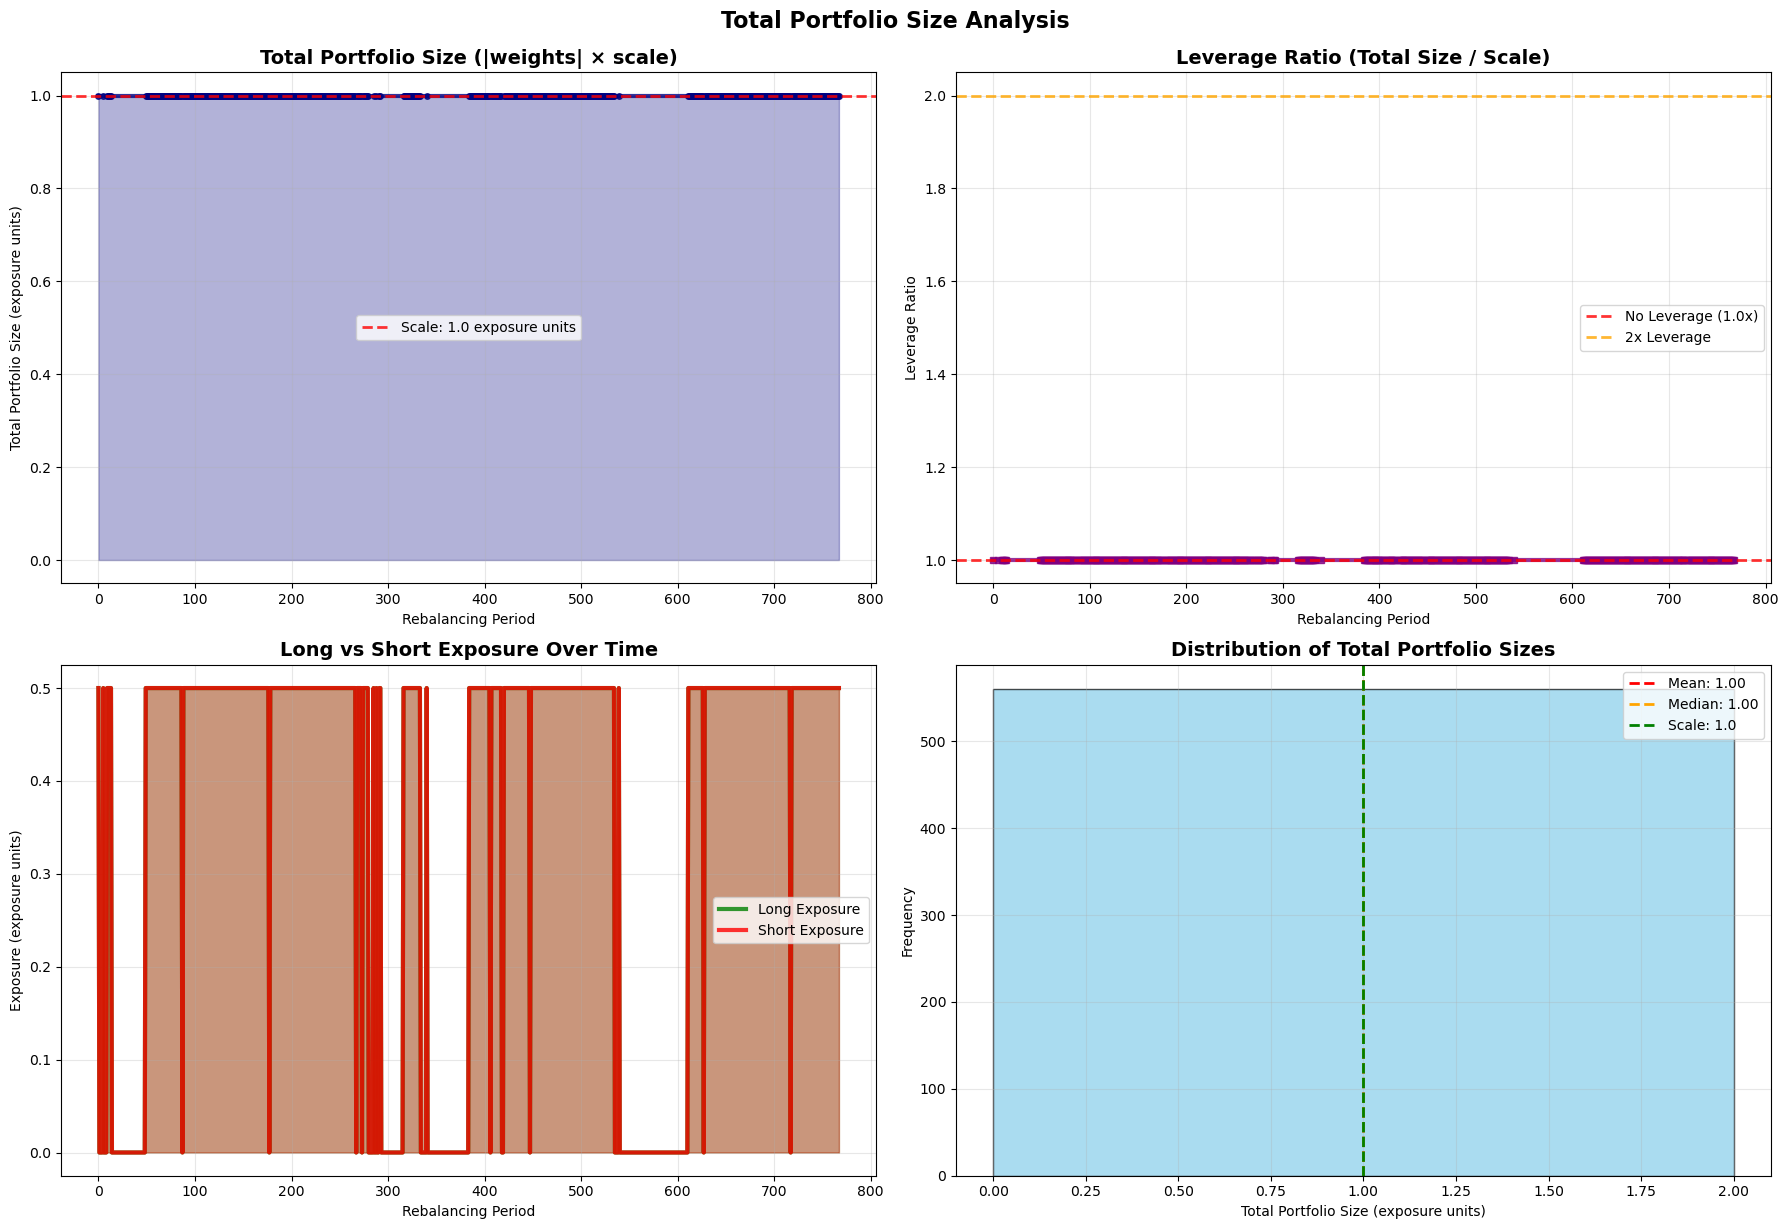

=== TOTAL PORTFOLIO SIZE STATISTICS ===
Capital scale per period: 1.0 (exposure units)
Number of rebalancing periods: 768
Periods with positions: 560
Average total portfolio size: 1.0000 exposure units
Maximum total portfolio size: 1.0000 exposure units
Minimum total portfolio size: 1.0000 exposure units
Std dev: 0.0000 exposure units
Average leverage ratio: 1.0000x
Maximum leverage ratio: 1.0000x
=== EXPOSURE BREAKDOWN ===
Total long exposure across all periods: 280.0000 exposure units
Total short exposure across all periods: 280.0000 exposure units
Total combined exposure: 560.0000 exposure units


In [13]:
# Total portfolio size & leverage summary
print("Calculating total portfolio size by summing absolute weights × capital_scale...")

total_long_exposure = allocations_df.get('total_long_exposure', pd.Series(0, index=allocations_df.index)).fillna(0)
total_short_exposure = allocations_df.get('total_short_exposure', pd.Series(0, index=allocations_df.index)).fillna(0)

total_exposure = total_long_exposure + total_short_exposure
total_portfolio_sizes = total_exposure * capital_scale

non_zero_mask = total_portfolio_sizes > 0
valid_portfolio_sizes = total_portfolio_sizes[non_zero_mask]

avg_portfolio_size = valid_portfolio_sizes.mean() if len(valid_portfolio_sizes) else 0
max_portfolio_size = valid_portfolio_sizes.max() if len(valid_portfolio_sizes) else 0
min_portfolio_size = valid_portfolio_sizes.min() if len(valid_portfolio_sizes) else 0

leverage_ratios = (total_portfolio_sizes / capital_scale).replace([np.inf, -np.inf], np.nan)
avg_leverage = leverage_ratios[non_zero_mask].mean() if non_zero_mask.any() else 0
max_leverage = leverage_ratios.max() if len(leverage_ratios) else 0

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

axes[0, 0].plot(np.arange(len(allocations_df))[non_zero_mask], total_portfolio_sizes[non_zero_mask],
                linewidth=3, color='navy', marker='o', markersize=4, alpha=0.8)
axes[0, 0].fill_between(np.arange(len(allocations_df))[non_zero_mask], total_portfolio_sizes[non_zero_mask], 0,
                        alpha=0.3, color='navy')
axes[0, 0].axhline(y=capital_scale, color='red', linestyle='--', linewidth=2,
                   label=f'Scale: {capital_scale} {capital_unit}', alpha=0.8)
axes[0, 0].set_title('Total Portfolio Size (|weights| × scale)', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Rebalancing Period')
axes[0, 0].set_ylabel(f'Total Portfolio Size ({capital_unit})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

stats_text = print(f"Avg: {avg_portfolio_size:,.2f} {capital_unit}Max: {max_portfolio_size:,.2f} {capital_unit}Min: {min_portfolio_size:,.2f} {capital_unit}")
axes[0, 0].text(0.02, 0.98, stats_text, transform=axes[0, 0].transAxes,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                verticalalignment='top', fontsize=10)

axes[0, 1].plot(np.arange(len(allocations_df))[non_zero_mask], leverage_ratios[non_zero_mask],
                linewidth=3, color='purple', marker='s', markersize=4, alpha=0.8)
axes[0, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='No Leverage (1.0x)', alpha=0.8)
axes[0, 1].axhline(y=2.0, color='orange', linestyle='--', linewidth=2, label='2x Leverage', alpha=0.8)
axes[0, 1].set_title('Leverage Ratio (Total Size / Scale)', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('Rebalancing Period')
axes[0, 1].set_ylabel('Leverage Ratio')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Long vs Short exposure
long_exposures = (total_long_exposure * capital_scale).values
short_exposures = (total_short_exposure * capital_scale).values
axes[1, 0].plot(np.arange(len(allocations_df)), long_exposures, linewidth=3, color='green', label='Long Exposure', alpha=0.8)
axes[1, 0].plot(np.arange(len(allocations_df)), short_exposures, linewidth=3, color='red', label='Short Exposure', alpha=0.8)
axes[1, 0].fill_between(np.arange(len(allocations_df)), long_exposures, 0, alpha=0.3, color='green')
axes[1, 0].fill_between(np.arange(len(allocations_df)), short_exposures, 0, alpha=0.3, color='red')
axes[1, 0].set_title('Long vs Short Exposure Over Time', fontweight='bold', fontsize=14)
axes[1, 0].set_xlabel('Rebalancing Period')
axes[1, 0].set_ylabel(f'Exposure ({capital_unit})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Distribution with guarded bins
if len(valid_portfolio_sizes) > 0:
    data_range = valid_portfolio_sizes.max() - valid_portfolio_sizes.min()
    if len(valid_portfolio_sizes) == 1 or data_range < 1e-9:
        bins = 1
        vmin = float(valid_portfolio_sizes.min())
        vmax = float(valid_portfolio_sizes.max())
        hist_range = (vmin - 1.0, vmax + 1.0)
    else:
        unique_vals = len(np.unique(valid_portfolio_sizes))
        bins = max(1, min(10, unique_vals, len(valid_portfolio_sizes)))
        hist_range = None

    axes[1, 1].hist(valid_portfolio_sizes, bins=bins, range=hist_range,
                    alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 1].axvline(avg_portfolio_size, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_portfolio_size:,.2f}')
    axes[1, 1].axvline(np.median(valid_portfolio_sizes), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(valid_portfolio_sizes):,.2f}')
    axes[1, 1].axvline(capital_scale, color='green', linestyle='--', linewidth=2, label=f'Scale: {capital_scale}')

axes[1, 1].set_title('Distribution of Total Portfolio Sizes', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel(f'Total Portfolio Size ({capital_unit})')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Total Portfolio Size Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print(f"=== TOTAL PORTFOLIO SIZE STATISTICS ===")
print(f"Capital scale per period: {capital_scale} ({capital_unit})")
print(f"Number of rebalancing periods: {len(allocations_df)}")
print(f"Periods with positions: {len(valid_portfolio_sizes)}")
print(f"Average total portfolio size: {avg_portfolio_size:,.4f} {capital_unit}")
print(f"Maximum total portfolio size: {max_portfolio_size:,.4f} {capital_unit}")
print(f"Minimum total portfolio size: {min_portfolio_size:,.4f} {capital_unit}")
print(f"Std dev: {valid_portfolio_sizes.std():,.4f} {capital_unit}" if len(valid_portfolio_sizes) > 0 else "Std dev: N/A")
print(f"Average leverage ratio: {avg_leverage:.4f}x")
print(f"Maximum leverage ratio: {max_leverage:.4f}x")

long_sum = long_exposures[non_zero_mask].sum() if non_zero_mask.any() else 0
short_sum = short_exposures[non_zero_mask].sum() if non_zero_mask.any() else 0
print(f"=== EXPOSURE BREAKDOWN ===")
print(f"Total long exposure across all periods: {long_sum:,.4f} {capital_unit}")
print(f"Total short exposure across all periods: {short_sum:,.4f} {capital_unit}")
print(f"Total combined exposure: {long_sum + short_sum:,.4f} {capital_unit}")


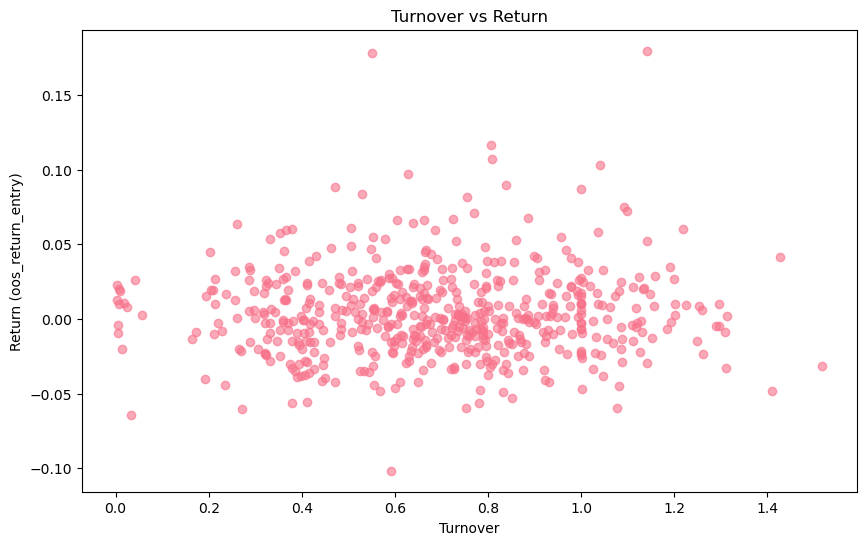

In [14]:
# Turnover vs. Performance
if 'turnover' in allocations_df.columns and RETURN_COL and RETURN_COL in allocations_df.columns:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(allocations_df['turnover'], allocations_df[RETURN_COL], alpha=0.6)
    ax.set_xlabel('Turnover')
    ax.set_ylabel(f'Return ({RETURN_COL})')
    ax.set_title('Turnover vs Return')
    plt.show()
else:
    print('Turnover or return column not present; skipping turnover vs return plot.')


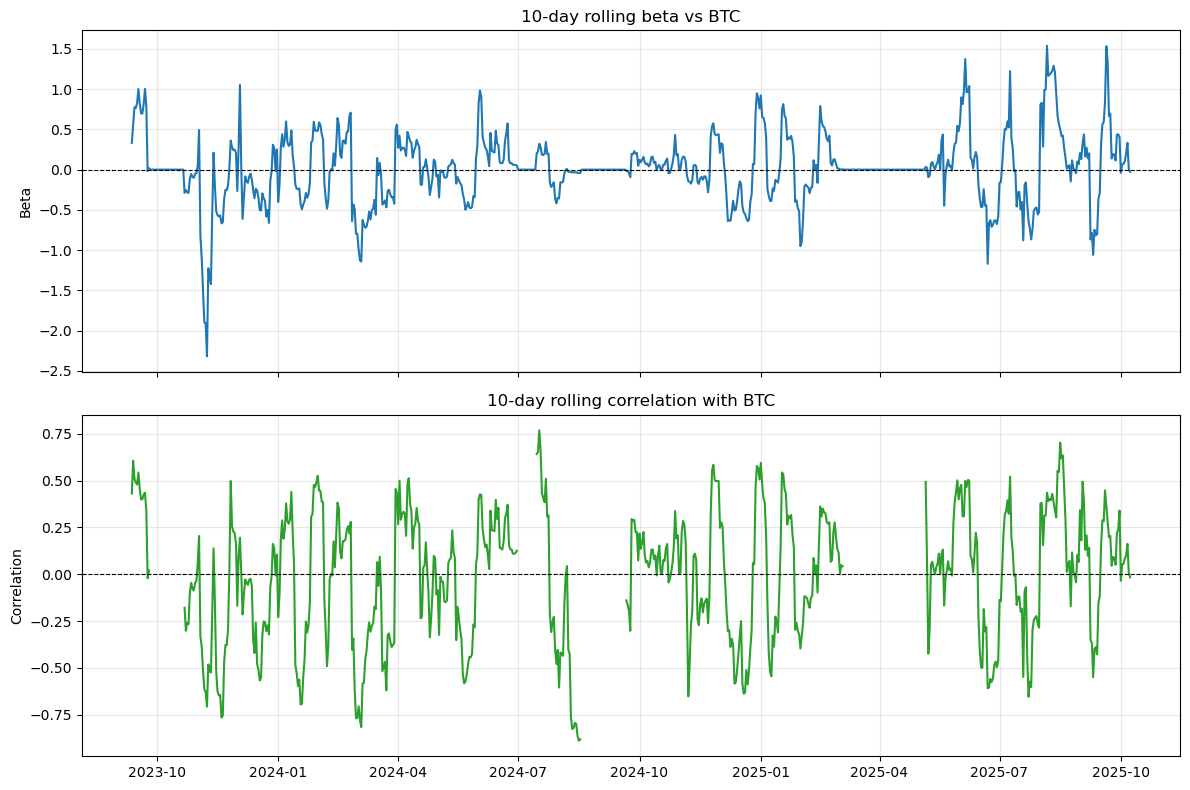

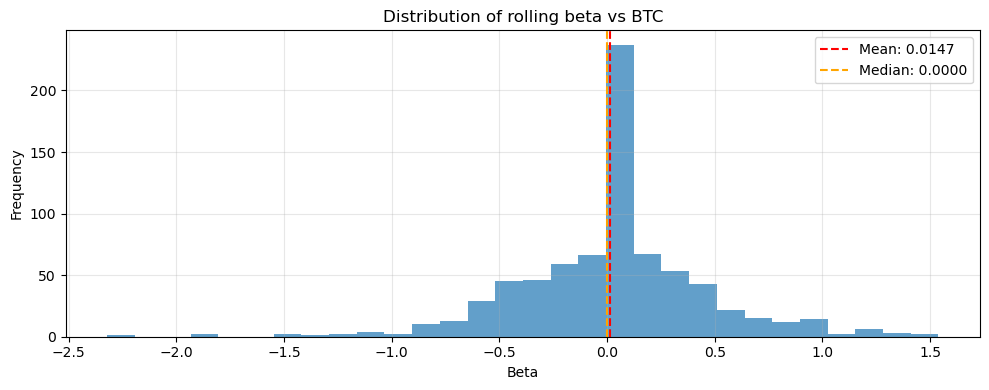

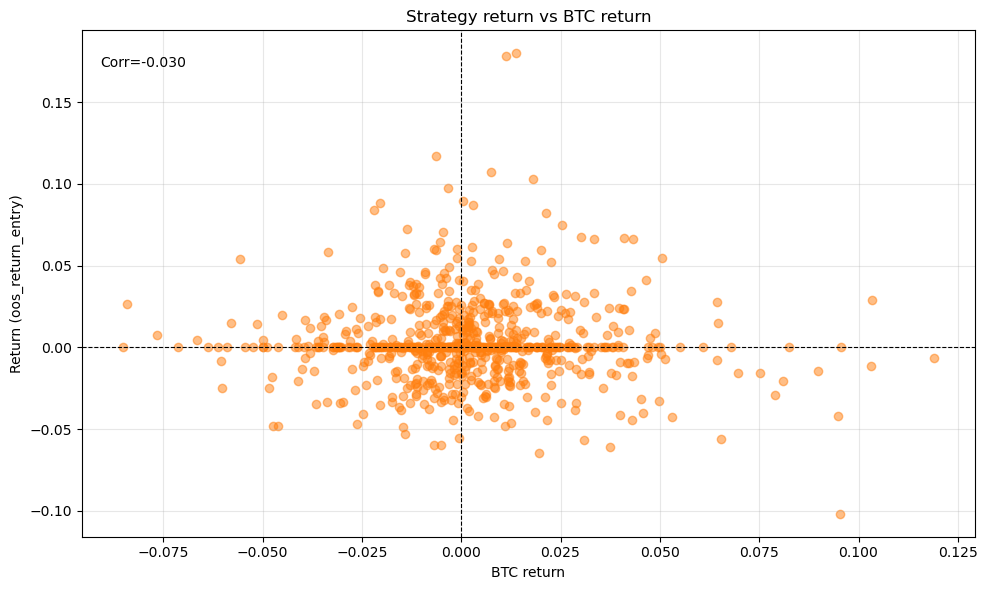

In [15]:

# Rolling beta and correlation vs BTC (10-day)
roll_window = 10
if RETURN_COL and 'btc_return' in allocations_df.columns:
    paired = allocations_df[['date', RETURN_COL, 'btc_return', 'total_long_exposure', 'total_short_exposure']].copy()
    paired['date'] = pd.to_datetime(paired['date'], errors='coerce')
    if hasattr(paired['date'], 'dt') and paired['date'].dt.tz is not None:
        paired['date'] = paired['date'].dt.tz_localize(None)

    # treat flat periods (no positions) as zero return so beta stays flat instead of NaN
    active_mask = (paired.get('total_long_exposure', 0).fillna(0) + paired.get('total_short_exposure', 0).fillna(0)) > 0
    paired['strat_ret_for_beta'] = paired[RETURN_COL]
    paired.loc[~active_mask, 'strat_ret_for_beta'] = 0.0

    paired = paired.dropna(subset=['date', 'btc_return'])
    if paired.empty:
        print('No overlapping strategy/BTC returns; skipping beta/correlation plots.')
    else:
        paired = paired.set_index('date').sort_index()
        cov = paired['strat_ret_for_beta'].rolling(roll_window).cov(paired['btc_return'])
        var = paired['btc_return'].rolling(roll_window).var()
        rolling_beta = cov / var.replace(0, np.nan)
        rolling_corr = paired['strat_ret_for_beta'].rolling(roll_window).corr(paired['btc_return'])
        paired = paired.assign(rolling_beta=rolling_beta, rolling_corr=rolling_corr)

        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        axes[0].plot(paired.index, paired['rolling_beta'], color='tab:blue')
        axes[0].axhline(0, color='black', lw=0.8, ls='--')
        axes[0].set_title(f'{roll_window}-day rolling beta vs BTC')
        axes[0].set_ylabel('Beta')
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(paired.index, paired['rolling_corr'], color='tab:green')
        axes[1].axhline(0, color='black', lw=0.8, ls='--')
        axes[1].set_title(f'{roll_window}-day rolling correlation with BTC')
        axes[1].set_ylabel('Correlation')
        axes[1].grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

        fig_hist, ax_hist = plt.subplots(figsize=(10, 4))
        ax_hist.hist(paired['rolling_beta'].dropna(), bins=30, color='tab:blue', alpha=0.7)
        ax_hist.set_title('Distribution of rolling beta vs BTC')
        ax_hist.set_xlabel('Beta')
        ax_hist.set_ylabel('Frequency')
        ax_hist.axvline(paired['rolling_beta'].mean(), color='red', linestyle='--', linewidth=1.5, label=f'Mean: {paired["rolling_beta"].mean():.4f}')
        ax_hist.axvline(paired['rolling_beta'].median(), color='orange', linestyle='--', linewidth=1.5, label=f'Median: {paired["rolling_beta"].median():.4f}')
        ax_hist.grid(True, alpha=0.3)
        ax_hist.legend()
        plt.tight_layout(); plt.show()

        fig2, ax2 = plt.subplots(figsize=(10, 6))
        ax2.scatter(paired['btc_return'], paired['strat_ret_for_beta'], alpha=0.5, color='tab:orange')
        ax2.axhline(0, color='black', lw=0.8, ls='--')
        ax2.axvline(0, color='black', lw=0.8, ls='--')
        ax2.set_title('Strategy return vs BTC return')
        ax2.set_xlabel('BTC return')
        ax2.set_ylabel(f'Return ({RETURN_COL})')
        corr_val = paired[['strat_ret_for_beta', 'btc_return']].corr().iloc[0,1]
        ax2.text(0.02, 0.95, f'Corr={corr_val:.3f}', transform=ax2.transAxes, ha='left', va='top')
        ax2.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()
else:
    print('Return column or BTC return missing; skipping beta/correlation plots.')


/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_36108/1076422938.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], data=melted, x='side', y='return', palette='pastel')


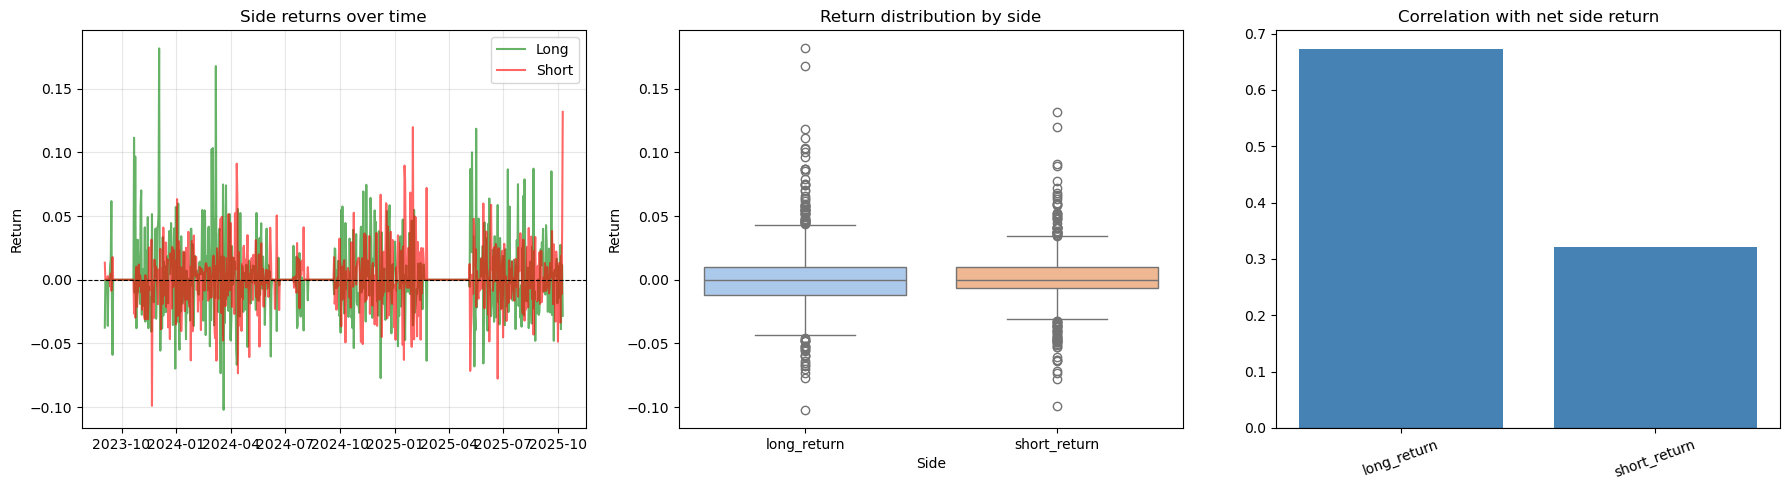

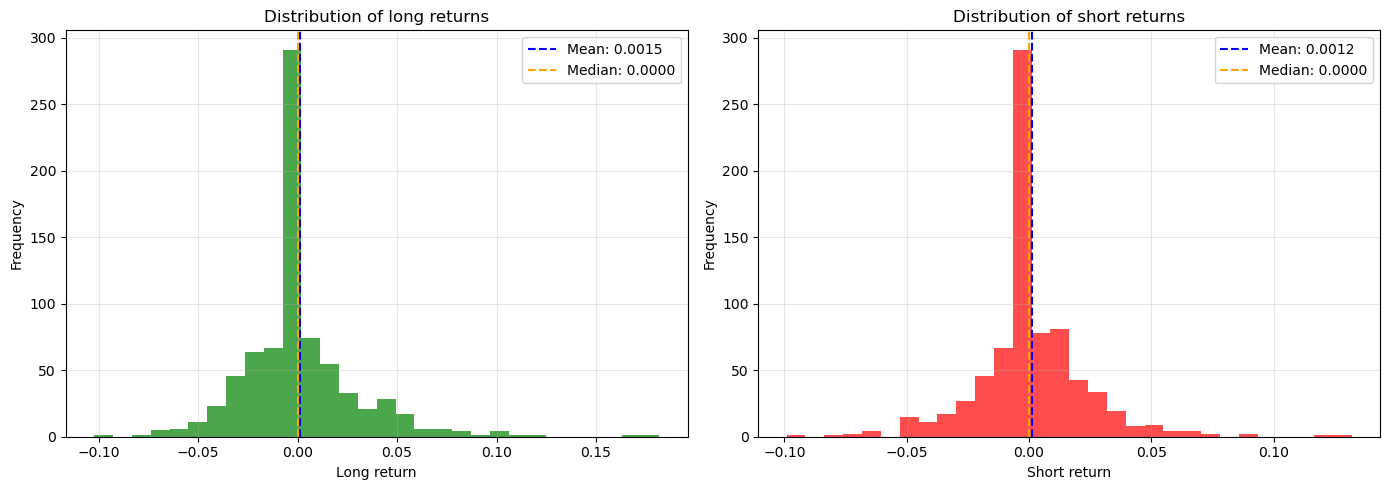

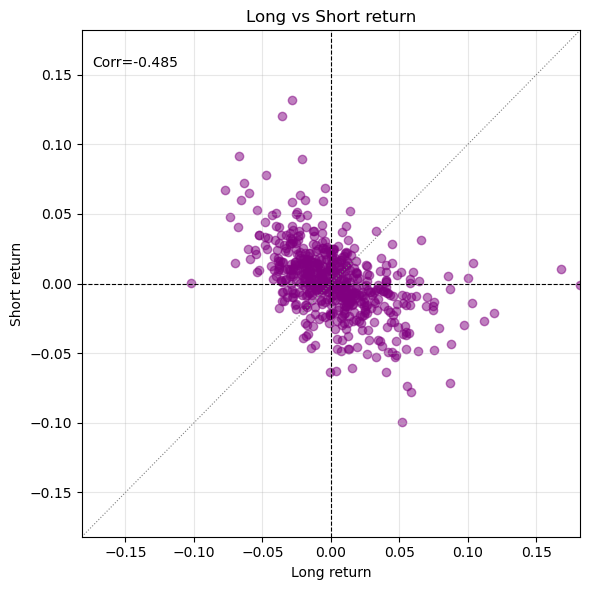

In [16]:

# Long vs short side returns
if {'long_return', 'short_return'}.issubset(allocations_df.columns):
    temp = allocations_df.dropna(subset=['long_return', 'short_return']).copy()
    if temp.empty:
        print('No side returns available.')
    else:
        temp['net_return_side'] = temp['long_return'] + temp['short_return']
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        axes[0].plot(temp['date'], temp['long_return'], label='Long', color='green', alpha=0.6)
        axes[0].plot(temp['date'], temp['short_return'], label='Short', color='red', alpha=0.6)
        axes[0].axhline(0, color='black', lw=0.8, ls='--')
        axes[0].set_title('Side returns over time')
        axes[0].set_ylabel('Return')
        axes[0].legend(); axes[0].grid(True, alpha=0.3)

        melted = temp[['long_return', 'short_return']].melt(var_name='side', value_name='return')
        sns.boxplot(ax=axes[1], data=melted, x='side', y='return', palette='pastel')
        axes[1].set_title('Return distribution by side')
        axes[1].set_xlabel('Side')
        axes[1].set_ylabel('Return')

        corr_vals = temp[['long_return', 'short_return', 'net_return_side']].corr().loc['net_return_side'].drop('net_return_side')
        axes[2].bar(corr_vals.index, corr_vals.values, color='steelblue')
        axes[2].axhline(0, color='black', lw=0.8)
        axes[2].set_title('Correlation with net side return')
        axes[2].tick_params(axis='x', rotation=20)

        plt.tight_layout(); plt.show()

        # Distributions by side
        fig_dist, axes_dist = plt.subplots(1, 2, figsize=(14, 5))
        for ax, series, title, color in [
            (axes_dist[0], temp['long_return'].dropna(), 'long', 'green'),
            (axes_dist[1], temp['short_return'].dropna(), 'short', 'red'),
        ]:
            ax.hist(series, bins=30, color=color, alpha=0.7)
            mean_val = series.mean() if not series.empty else None
            med_val = series.median() if not series.empty else None
            if mean_val is not None and pd.notna(mean_val):
                ax.axvline(mean_val, color='blue', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.4f}')
            if med_val is not None and pd.notna(med_val):
                ax.axvline(med_val, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {med_val:.4f}')
            ax.set_title(f'Distribution of {title} returns')
            ax.set_xlabel(f'{title.capitalize()} return')
            ax.set_ylabel('Frequency')
            ax.grid(True, alpha=0.3)
            ax.legend()
        plt.tight_layout(); plt.show()

        # Scatter: long vs short return
        fig_sc, ax_sc = plt.subplots(figsize=(6, 6))
        ax_sc.scatter(temp['long_return'], temp['short_return'], alpha=0.5, color='purple')
        ax_sc.axhline(0, color='black', lw=0.8, ls='--')
        ax_sc.axvline(0, color='black', lw=0.8, ls='--')
        lim = max(abs(temp['long_return']).max(), abs(temp['short_return']).max())
        if pd.notna(lim) and lim > 0:
            ax_sc.set_xlim(-lim, lim)
            ax_sc.set_ylim(-lim, lim)
            ax_sc.plot([-lim, lim], [-lim, lim], color='gray', lw=0.8, ls=':')
        corr_val = temp[['long_return', 'short_return']].corr().iloc[0,1]
        ax_sc.text(0.02, 0.95, f'Corr={corr_val:.3f}', transform=ax_sc.transAxes, ha='left', va='top')
        ax_sc.set_title('Long vs Short return')
        ax_sc.set_xlabel('Long return')
        ax_sc.set_ylabel('Short return')
        ax_sc.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()
else:
    print('Side return columns not present; compute them first.')


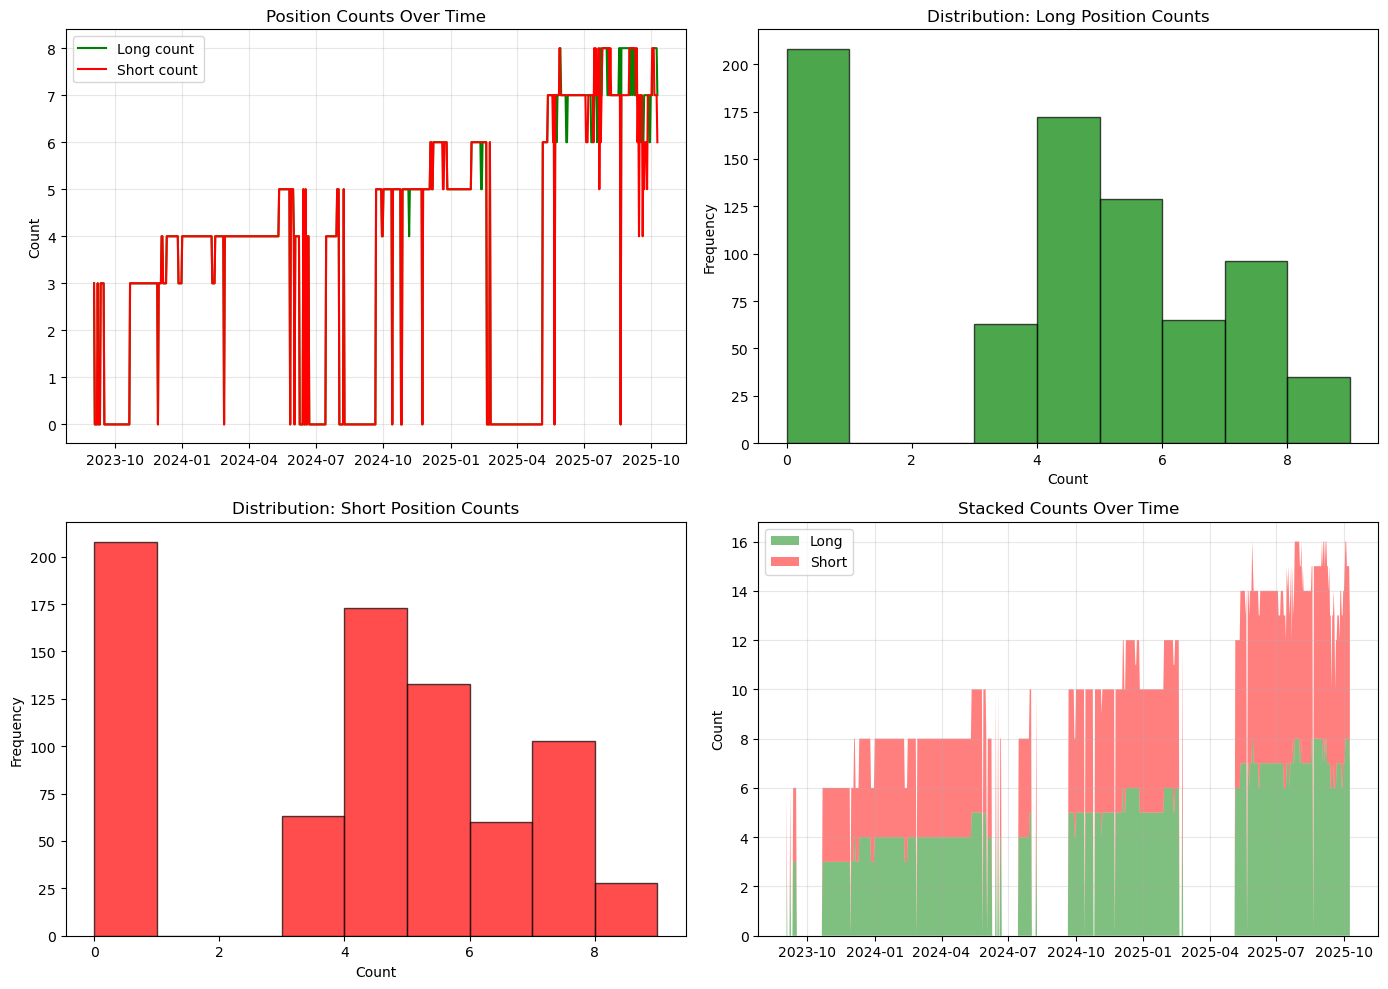

In [17]:
# Number of long vs short coins over time + distributions
if {'long_positions', 'short_positions'}.issubset(set(allocations_df.columns)):
    fig, axes = plt.subplots(2, 2, figsize=(14,10))
    # time series
    axes[0,0].plot(allocations_df['date'], allocations_df['long_positions'], label='Long count', color='green')
    axes[0,0].plot(allocations_df['date'], allocations_df['short_positions'], label='Short count', color='red')
    axes[0,0].set_title('Position Counts Over Time')
    axes[0,0].set_ylabel('Count'); axes[0,0].legend(); axes[0,0].grid(True, alpha=0.3)

    # hist long counts
    axes[0,1].hist(allocations_df['long_positions'].dropna(), bins=range(int(allocations_df['long_positions'].max())+2), color='green', alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Distribution: Long Position Counts'); axes[0,1].set_xlabel('Count'); axes[0,1].set_ylabel('Frequency')

    # hist short counts
    axes[1,0].hist(allocations_df['short_positions'].dropna(), bins=range(int(allocations_df['short_positions'].max())+2), color='red', alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Distribution: Short Position Counts'); axes[1,0].set_xlabel('Count'); axes[1,0].set_ylabel('Frequency')

    # stacked area for mix
    axes[1,1].stackplot(allocations_df['date'], allocations_df['long_positions'], allocations_df['short_positions'], labels=['Long', 'Short'], colors=['green','red'], alpha=0.5)
    axes[1,1].set_title('Stacked Counts Over Time'); axes[1,1].set_ylabel('Count'); axes[1,1].legend(); axes[1,1].grid(True, alpha=0.3)
    plt.tight_layout()
else:
    print('Position count columns not present; cannot plot counts/distributions.')


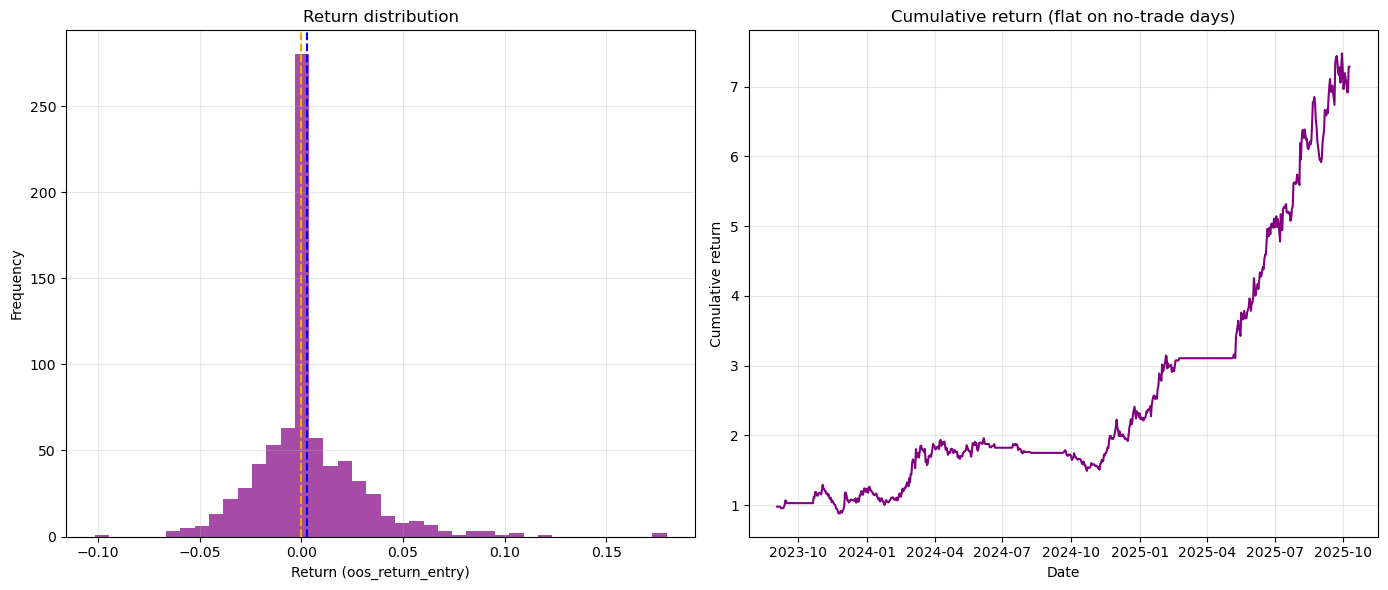

Return stats (oos_return_entry): mean=0.0029, median=0.0000, std=0.0258, min=-0.1017, max=0.1798


In [18]:

# Distribution of strategy returns (if available)
if RETURN_COL and RETURN_COL in allocations_df.columns:
    returns_series = allocations_df.set_index('date')[RETURN_COL]
    returns = returns_series  # keep original for distribution (dropping NaN below)
    fig, axes = plt.subplots(1,2, figsize=(14,6))

    if len(returns) == 0:
        print(f'{RETURN_COL} present but empty; skipping plots.')
    else:
        non_nan = returns.dropna()
        data_range = non_nan.max() - non_nan.min() if len(non_nan) else 0
        if len(non_nan) <= 1 or data_range < 1e-9:
            bins = 1
            hist_range = (float(non_nan.min()) - 1e-6, float(non_nan.max()) + 1e-6) if len(non_nan) else None
        else:
            bins = max(1, min(40, non_nan.nunique(), len(non_nan)))
            hist_range = None
        axes[0].hist(non_nan, bins=bins, range=hist_range, color='purple', alpha=0.7)
        axes[0].axvline(non_nan.mean(), color='blue', linestyle='--', linewidth=1.5, label=f'Mean: {non_nan.mean():.4f}')
        axes[0].axvline(non_nan.median(), color='orange', linestyle='--', linewidth=1.5, label=f'Median: {non_nan.median():.4f}')
        axes[0].set_title('Return distribution')
        axes[0].set_xlabel(f'Return ({RETURN_COL})')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True, alpha=0.3)

        returns_with_flats = returns_series.fillna(0)
        axes[1].plot(returns_with_flats.index, (1 + returns_with_flats).cumprod(), color='purple')
        axes[1].set_title('Cumulative return (flat on no-trade days)')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Cumulative return')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout(); plt.show()
        print(f"Return stats ({RETURN_COL}): mean={non_nan.mean():.4f}, median={non_nan.median():.4f}, std={non_nan.std():.4f}, min={non_nan.min():.4f}, max={non_nan.max():.4f}")
else:
    print('Return column not present; cannot plot return distribution.')

